# In this notebook: 


* features cleaning 
* features visualization
* features selection by: 
  * variance (t test)
  * correlation
* features scaling??? -> https://towardsdatascience.com/machine-learning-with-python-classification-complete-tutorial-d2c99dc524ec


TODO: 
 pca https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60 
 https://www.datacamp.com/community/tutorials/feature-selection-python?utm_source=adwords_ppc&utm_campaignid=898687156&utm_adgroupid=48947256715&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=229765585186&utm_targetid=dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=1008002&gclid=CjwKCAjwqvyFBhB7EiwAER786XGjif4x0BheNUuX3mOU_G1uuBQA7pexT8kwhnE__T4_7Nt1bkyK4xoCuLIQAvD_BwE





## Load data

In [164]:
from google.colab import files, drive
import glob, os
import pandas as pd

In [165]:
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/eeg_data_science/Results/4.Features/data.csv"
features_df = pd.read_csv(data_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [166]:
import pandas as pd
from pandas.api.types import is_numeric_dtype

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind


## Clean dataframe

In [167]:
# remove metadata 
degree = [col for col in features_df.columns[2:] if 'degree' in col]
columns_to_drop = ['idx', 'sub_num', 'file_name', 'task', 'meta_data', 'spect_data', 'conn_data', 'date']
columns_to_drop = columns_to_drop + degree

features_df = features_df.drop(columns=columns_to_drop)

## Visualization

In [168]:
df.describe()

,Value
count,18.000000
mean,2.261345
std,2.337897
min,0.326170
25%,0.657184
50%,1.429935
75%,2.864035
max,8.091378


Text(0.5, 1.0, 'Mean of Broadband Features')

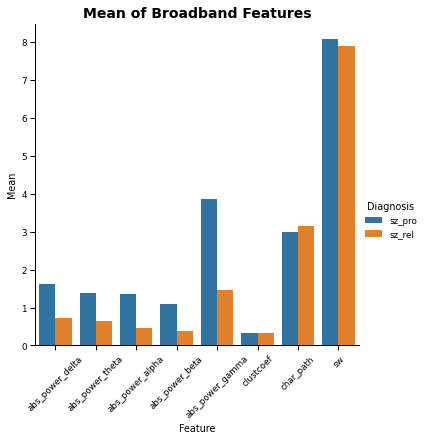

In [169]:
broad_data = [col for col in features_df.columns[2:] if 'broad' in col]

broad_df = features_df.groupby('diagnosis')[broad_data].mean().stack().reset_index()
broad_df.columns=['Diagnosis', 'Feature', 'Mean']
broad_df['Feature'] = broad_df['Feature'].str.replace('_broadband', '')

sns.catplot(data = broad_df, kind='bar', x='Feature', y='Mean', hue='Diagnosis')
plt.xticks(rotation=45)

plt.title('Mean of Broadband Features', fontsize=14, fontweight='bold')

Text(0.5, 1.0, 'Mean and STD for each Feature')

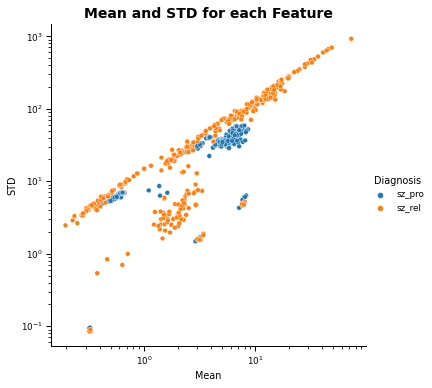

In [170]:

mean_std_df = features_df.groupby('diagnosis').mean().stack().reset_index()
mean_std_df.columns=['Diagnosis', 'Feature', 'Mean']
std = features_df.groupby('diagnosis').std().stack().reset_index()
std.columns=['Diagnosis', 'Feature', 'STD']
mean_std_df = mean_std_df.merge(std)
g = sns.relplot(data=mean_std_df, x="Mean", y="STD", hue="Diagnosis",)
g.set(xscale="log", yscale="log")
plt.title('Mean and STD for each Feature', fontsize=14, fontweight='bold')

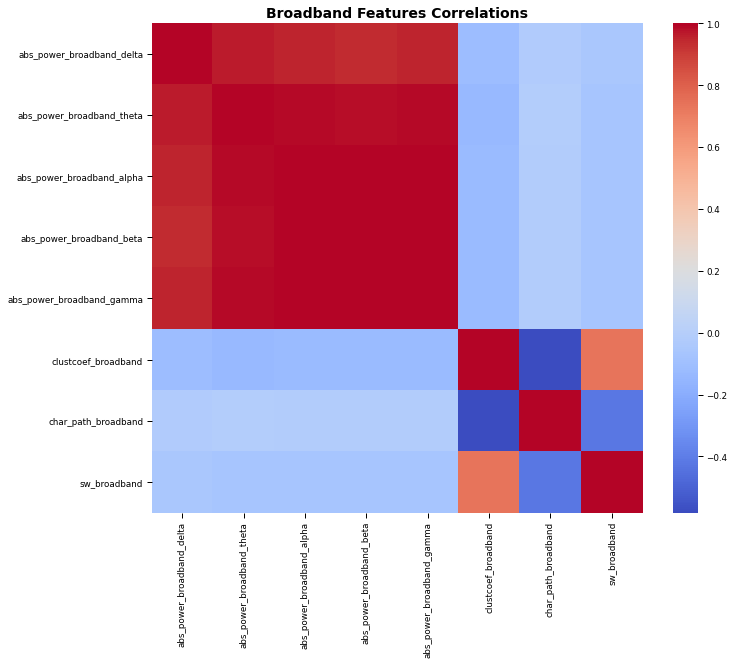

In [171]:
vis_correlation_df = features_df[broad_data].corr()
plt.subplots(figsize=(11,9))
sns.heatmap(vis_correlation_df, cmap='coolwarm')
plt.title('Broadband Features Correlations', fontsize=14, fontweight='bold')
plt.show()

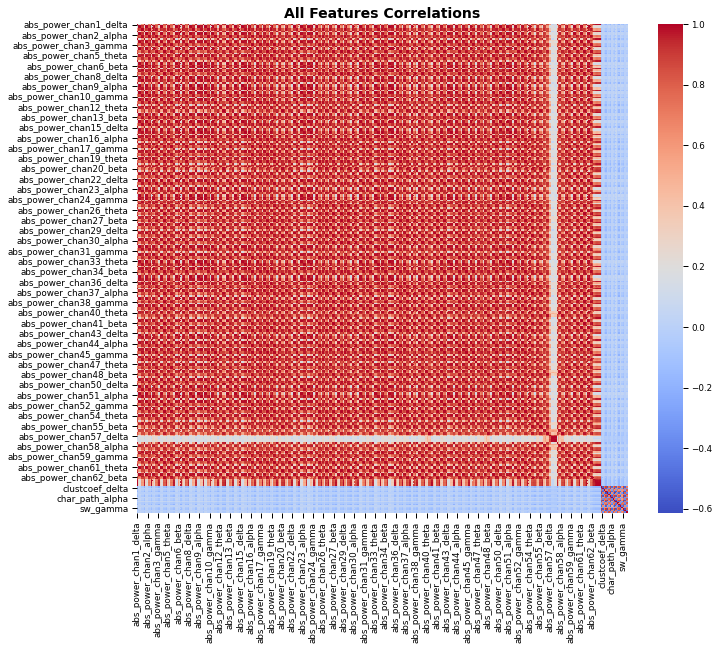

In [172]:
correlation_df = features_df.corr()
plt.subplots(figsize=(11,9))
sns.heatmap(correlation_df, cmap='coolwarm')
plt.title('All Features Correlations', fontsize=14, fontweight='bold')
plt.show()

## Selection

In [173]:
num_features = [col for col in features_df.columns if is_numeric_dtype(features_df[col])]

ttest_results = pd.DataFrame(columns=['Feature', 'pValue'])
i = 0 
for feat in num_features: 
  ttest = ttest_ind(*features_df.groupby('diagnosis')[feat].apply(lambda x:list(x)))
  ttest_results = ttest_results.append(pd.DataFrame({'Feature': feat, 'pValue': ttest[1]}, index=[i]))
  i+=1 

ttest_results[ttest_results['pValue']<0.05]
ttest_results = ttest_results.sort_values("pValue")

features_to_use = list(ttest_results['Feature'][0:150])

In [174]:
correlation_df = correlation_df.abs()
feat_corr = [[col, sum(correlation_df[col])] for col in list(correlation_df.columns)]
feat_corr = pd.DataFrame(feat_corr, columns=['Feature', 'sum_corr'])

feat_corr = feat_corr.sort_values("sum_corr")

features_to_use = features_to_use + list(feat_corr['Feature'][0:150])

## Save X, y

In [175]:
# move diagnosis and sub_num to a different df 

features_to_use = set(features_to_use)
X = features_df[features_to_use]
tag_column = ['diagnosis']
y = features_df[tag_column]

data_path = "/content/drive/MyDrive/eeg_data_science/Results/5.For_Modeling/"


X.to_csv(data_path + 'X.csv')
y.to_csv(data_path + 'y.csv')